# Groningen reservoir model
This notebook allows running the reservoir model developped at GMG for gas extraction from the Groningen gas field following Meyer et al., 2022.

The most complete description of the model can be found in:
Meyer, H., Smith, J. D., Bourne, S., & Avouac, J. P. (2023). An integrated framework for surface deformation modeling and induced seismicity forecasting due to reservoir operations. Geological Society, London, Special Publications, 528(1), SP528-2022.

A full description of the needed libraries and tested practice on installation and running can be found in the file: Groningen_GMG_Reservoir_model_libraries.txt

A description of the integration of this module with the rest of the modelling workflow can be found in the file:
../README_GroningenModels_GMG.txt

## 1. Libraries, functions, and data loading

### 1.1 Import librairies

In [1]:
print ('Importing librairies...')

# System operations
import sys
from time import time
# Math, Array and Dataformating
import numpy as np
import pandas as pd
import math
from scipy.interpolate import griddata
# Plotting
from shapely.geometry import Point as ShapelyPoint
from shapely.geometry.polygon import Polygon as ShapelyPolygon
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Wedge, Polygon
# Gaussian Smoothing
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve

# VFE modules
from fenics import *
import time as tm
from scipy import signal
from mshr import *

print ('Librairies imported')

Importing librairies...
Librairies imported


In [2]:
# Import functions
print ('Importing auxiliary functions...')
from util.auxiliary import *
print ('Auxiliary functions imported')

Importing auxiliary functions...
Auxiliary functions imported


### 1.2 Define the folders to be used

In [3]:
data_folder = '../Reservoir_data/'
results_folder = '../Simulation_results/'

### 1.3 Load reservoir data

Loading reservoir data...


/Users/michellejaramillo/Documents/GMG_DeepDive2024/cleancodes_groningen_GMG_V0.2/GroningenModels/Groningen_GMG_Reservoir_model/Functions/auxiliary_functions.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[col].iloc[idx0:idx1 + 1] = data[col]  # Insert updated data


Reservoir data loaded


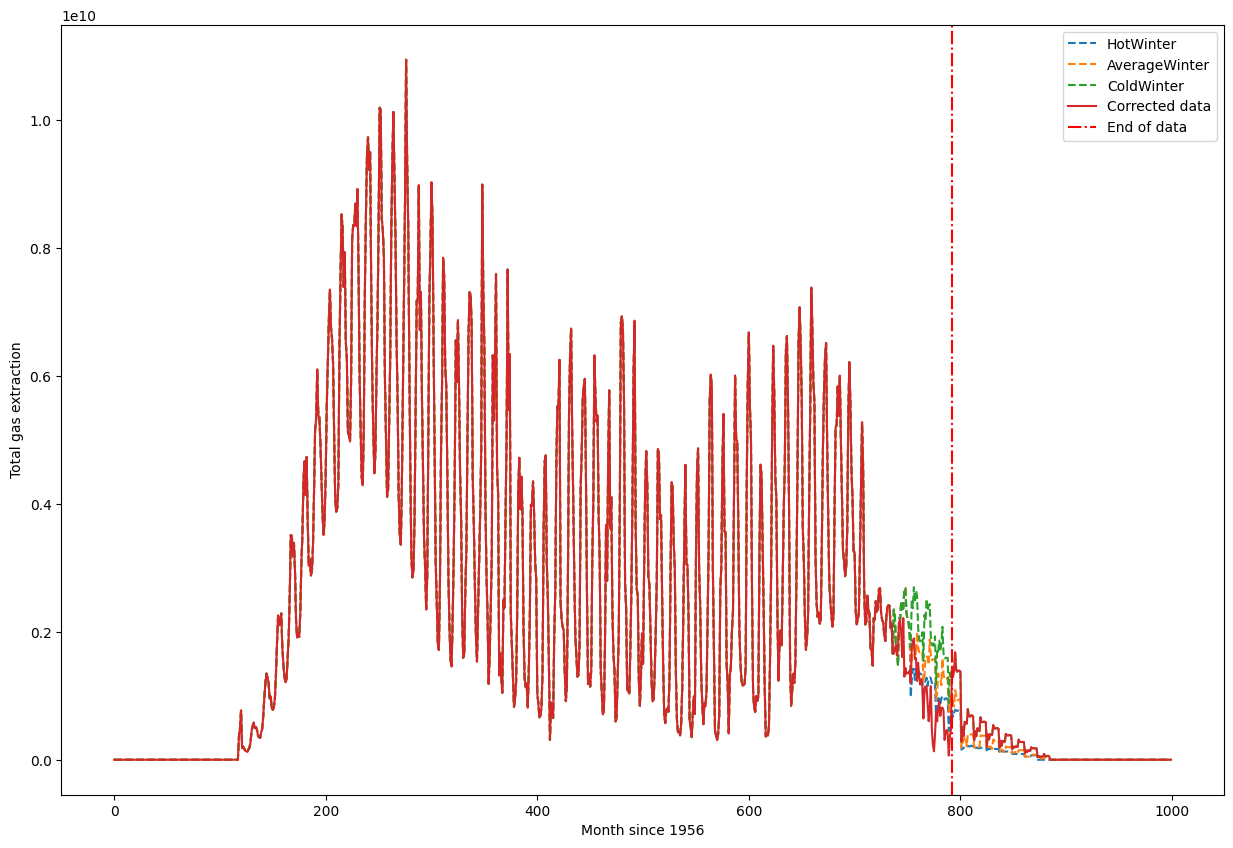

In [4]:
print ('Loading reservoir data...')
# Reservoir data
X, Y = np.mgrid[221.250:269.750:0.500, 566.000:615.500:0.500] # in km
Thickness = np.load(data_folder + 'ReservoirThickness.npy') / 1e3 #in km
Outline = pd.DataFrame(np.load(data_folder + 'ReservoirOutline.npy')) / 1e3 #dim change

# Gas extraction data
GasMolWeight = 18.3815e-3  # kg.mol-1
GasData = np.load(data_folder + 'WellInformation.npy', allow_pickle=True).item() # the information on the well clusters and gas extraction data
GasExtractionData = UpdateGasExtractionData(GasData_file =  data_folder+'WellInformation.npy',winter = 'ColdWinter',Excel_file = data_folder+'Gaswinning-maandelijks_2010_2022.xlsx',plot_YN=True,Extrapolate_increase=False)
# Data from 1956 to 2039 the last years from 2022 onward are previsions of gas extraction. Here we use the cold winter scenario but it can be changed

BottomHP = GasData['PressureMeasurements'] #The bottomhole pressure measurements for history matching
Well = GasData['WellLocations']  #The well cluster locations
print ("Reservoir data loaded")

# the previous line is optional

### 1.4 Wells data

In [5]:
from util.well_config import create_well_configuration

#Chose here your well configuration (only for control process)
# 1 : one central well
# 2 : two wells (one north and one south)
# 5 : One central well surrounded by four other wells
# 29 : All real wells' positions
well_configuration = 29

#Well and GasData are arguments so that the function knows the real wells positions for configuration 29
wells_names, wells_locations, Well, initial_extraction_data = create_well_configuration(well_configuration, Well, GasData)

historic_extraction = np.nan_to_num(GasExtractionData.fillna(0).rolling(1).mean().to_numpy()) /(30.4375*24) # convert units to bbm/month
extraction_data = []
for ii in range(historic_extraction.shape[0]):
    extraction_data.append(pd.Series(data=historic_extraction[ii,:].tolist(),index=wells_names))


## 2. Run the model

### 2.1 Creation of the diffusion model

In [6]:
from util.diffusion_model import DiffusionModel

#Define an iteration for the change in gas saturation.
TimeNewInit = 431 
# This is used to simulate an artificial change in gas saturation at a given iteration it can be removed
#its value is : 431 -- corresponds to the nmber of months over 1957-1992

#Create the diffusion model class
DiffMod = DiffusionModel(X, #X and Y are the spatial meshgrid [221250:269750:500, 566000:615500:500]
                         Y,
                         Thickness, #Table loaded from ReservoirThickness.npy
                         385, #Temperature in K
                         34.68, #Initial pressure in MPa
                         GasMolWeight,
                         TimeNewInit,
                         2629800. / 3600, #In seconds, corresponds to 1 month, used for dimension change
                         GasExtractionData,
                         Well, #Table with 1 line per well (column 0 : name, columns 1 and 2 : coordinates)
                         Outline)

#Dump the unstructured mesh of the reservoir to a numpy file for later use
MESH = DiffMod.coordinates2_
with open(results_folder+'MESH.npy', 'wb') as f:
    np.save(f,MESH)
    
    
#Parameters for the pressure model deduced from first history matching (1957-1992)
optimal_permeability = 2.5e-13 * 1e-6 #dimension change, permeability dimension : m^2
optimal_porosity = 0.16
optimal_gas_saturation = 0.31
optimal_gas_saturation2 = 0.357

Calling FFC just-in-time (JIT) compiler, this may take some time.


### 2.2 Main loop

In [7]:
#Creation of empty lists which will contain the results
pressures_list = []
extractions_list = []
deformations_list = []

#Definition on initial pressure and gas extraction
initial_pressure = np.ones(MESH.shape[0]) * 34.68 #dim change, pressure change
pressures_list.append(initial_pressure)
# extractions_list.append(initial_extraction_data)
extractions_list.append(extraction_data[0])


In [ ]:
### MAIN DIFFUSION SIMULATION LOOP ###

#Always run the previous cell before this one, otherwise pressures_list, extractions_list and deformations_list won't be reset

nb_iterations = 1000 #One iteration = one month

t_begin = time()

for i in range (1,nb_iterations) :
    #Set gas saturation to the new value since 1991 :
    if i > TimeNewInit :
       optimal_gas_saturation = optimal_gas_saturation2
    
    print (f'Progression : {int(i/nb_iterations*100)}%')

    #Get last values for pressure and gas_extraction
    pres = pressures_list[-1]
    gas_extraction = extractions_list[-1]

    #Compute the new pressure
    new_pres = DiffMod.diffusion_process_for_control(optimal_permeability,optimal_porosity,optimal_gas_saturation, pres, gas_extraction)
    pressures_list.append(new_pres)
    #Set extraction values for the next iteration
    new_extraction = pd.Series(data=historic_extraction[i,:].tolist(),index=wells_names) #Here we use a constant extraction rate
    extractions_list.append(new_extraction)
   


t_end = time()

print ('Total time for main loop : ' + str(t_end-t_begin))
print ('Mean time per iteration : ' + str((t_end-t_begin)/nb_iterations))

Progression : 0%
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


Progression : 91%
Progression : 92%
Progression : 92%
Progression : 92%
Progression : 92%
Progression : 92%
Progression : 92%
Progression : 92%
Progression : 92%
Progression : 92%
Progression : 92%
Progression : 93%
Progression : 93%
Progression : 93%
Progression : 93%
Progression : 93%
Progression : 93%
Progression : 93%
Progression : 93%
Progression : 93%
Progression : 93%
Progression : 94%
Progression : 94%
Progression : 94%
Progression : 94%
Progression : 94%
Progression : 94%
Progression : 94%
Progression : 94%
Progression : 94%
Progression : 94%
Progression : 95%
Progression : 95%
Progression : 95%
Progression : 95%
Progression : 95%
Progression : 95%
Progression : 95%
Progression : 95%
Progression : 95%
Progression : 95%
Progression : 96%
Progression : 96%
Progression : 96%
Progression : 96%
Progression : 96%
Progression : 96%
Progression : 96%
Progression : 96%
Progression : 96%
Progression : 96%
Progression : 97%
Progression : 97%
Progression : 97%
Progression : 97%
Progressio

### 2.3 Save simulation results

In [ ]:
print ('Saving simulations results...')
with open(results_folder + 'extractions_list.npy', 'wb') as f:
    np.save(f,extractions_list)
with open(results_folder + 'pressures_list.npy', 'wb') as f:
    np.save(f,pressures_list)
print ("[DONE]")


## 3. Plots

### 3.1 Timeseries

In [ ]:
# fist plot: temporal evolution

fig,axs = plt.subplots(3,1,figsize=(10,15))
ax=axs[0]
extractions_sum = [np.sum(extractions_list[ii]) for ii in range(len(extractions_list))]
ax.plot(extractions_sum,c='k',lw=3)
ax.set_xlabel('Month since 1956.01')
ax.set_ylabel('Total extraction')
ax=axs[1]
extractions_indwells = [[extractions_list[ii][well] for ii in range(len(extractions_list))] for well in range(Well.shape[0])]
for well in range(Well.shape[0]):
    ax.plot(extractions_indwells[well],alpha=0.5)
ax.set_xlabel('Month since 1956.01')
ax.set_ylabel('Individual well extraction')
ax=axs[2]
pressures_avg = [np.mean(pressures_list[ii]) for ii in range(len(extractions_list))]
ax.plot(pressures_avg,c='navy',lw=3)
ax.set_xlabel('Month since 1956.01')
ax.set_ylabel('Average reservoir pressure')

### 3.2 Maps

In [ ]:
# second plot: top view maps
plot_iterations = [100,200,500,800]

extractions_indwells = [[extractions_list[ii][well] for ii in range(len(extractions_list))] for well in range(Well.shape[0])]
vmin_e = np.min([np.min(extraction) for extraction in extractions_indwells])
vmax_e = np.max([np.max(extraction) for extraction in extractions_indwells])

vmin_p = 5
vmax_p = 35


fig,axs = plt.subplots(2,len(plot_iterations),figsize=(5*len(plot_iterations),10))
for kk in range(len(plot_iterations)):
    ax = axs[0,kk]
    plot_it = plot_iterations[kk]
    for well in range(Well.shape[0]):
        quad1 = ax.scatter(float(Well[well,1]),float(Well[well,2]),c=np.sum(extractions_indwells[well][:plot_it]),vmin=vmin_e,vmax=vmax_e,cmap='coolwarm')
        ax.text(float(Well[well,1]),float(Well[well,2])-1,Well[well,0])
    ax.plot(Outline[2],Outline[3],c='k')
    ax.set_aspect('equal')
    ax.set_title(f'After {plot_it} months')

for kk in range(len(plot_iterations)):
    ax = axs[1,kk]
    plot_it = plot_iterations[kk]
    quad2 = ax.scatter(MESH[:,0],MESH[:,1],c=pressures_list[plot_it],vmin=vmin_p,vmax=vmax_p,cmap='PuBuGn')
        
    ax.plot(Outline[2],Outline[3],c='k')
    ax.set_aspect('equal')
    
cb_extr = fig.colorbar(quad1,ax=axs[0,-1],orientation='vertical',label='Cumulative extraction (Mm3)')
cb_press = fig.colorbar(quad2,ax=axs[1,-1],orientation='vertical',label='Pressure (MPa)')


plt.tight_layout()
plt.subplots_adjust(wspace=-0.4,hspace=0.08)